In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

# sin波にノイズを付与する
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

f = toy_problem()

In [15]:
f.shape

(201,)

In [3]:
def make_dataset(low_data, n_prev=100):

    data, target = [], []
    maxlen = 25

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target


#g -> 学習データ，h -> 学習ラベル
g, h = make_dataset(f)

In [11]:
print(g.shape)
print(h.shape)

(176, 25, 1)
(176, 1)


In [5]:
future_test = g[175].T

In [6]:
# モデル構築

# 1つの学習データのStep数(今回は25)
length_of_sequence = g.shape[1] 
in_out_neurons = 1
n_hidden = 300

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(g, h,
          batch_size=300,
          epochs=100,
          validation_split=0.1,
          callbacks=[early_stopping]
          )

Instructions for updating:
Use tf.cast instead.
Train on 158 samples, validate on 18 samples
Epoch 1/100
158/158 [==============================] - 3s 21ms/step - loss: 0.5104 - val_loss: 0.1368
Epoch 2/100
158/158 [==============================] - 0s 3ms/step - loss: 0.3305 - val_loss: 0.0449
Epoch 3/100
158/158 [==============================] - 1s 3ms/step - loss: 0.1963 - val_loss: 0.0410
Epoch 4/100
158/158 [==============================] - 0s 3ms/step - loss: 0.1116 - val_loss: 0.1653
Epoch 5/100
158/158 [==============================] - 0s 3ms/step - loss: 0.1000 - val_loss: 0.2083
Epoch 6/100
158/158 [==============================] - 0s 3ms/step - loss: 0.0960 - val_loss: 0.1300
Epoch 7/100
158/158 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0593
Epoch 8/100
158/158 [==============================] - 1s 4ms/step - loss: 0.0366 - val_loss: 0.0241
Epoch 9/100
158/158 [==============================] - 0s 3ms/step - loss: 0.0316 - val_loss: 0.01

In [8]:
# 予測
predicted = model.predict(g)

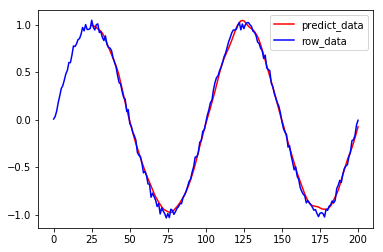

In [9]:
plt.figure()
plt.plot(range(25,len(predicted)+25),predicted, color="r", label="predict_data")
plt.plot(range(0, len(f)), f, color="b", label="row_data")
plt.legend()
plt.show()

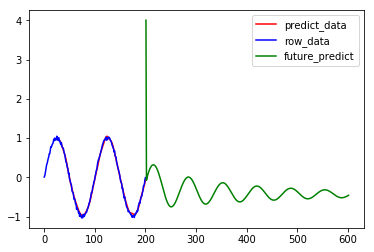

In [10]:
# 1つの学習データの時間の長さ -> 25
time_length = future_test.shape[1]
# 未来の予測データを保存していく変数
future_result = np.empty((1))

# 未来予想
for step2 in range(400):

    test_data = np.reshape(future_test, (1, time_length, 1))
    batch_predict = model.predict(test_data)

    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)

    future_result = np.append(future_result, batch_predict)


# sin波をプロット
plt.figure()
plt.plot(range(25,len(predicted)+25),predicted, color="r", label="predict_data")
plt.plot(range(0, len(f)), f, color="b", label="row_data")
plt.plot(range(0+len(f), len(future_result)+len(f)), future_result, color="g", label="future_predict")
plt.legend()
plt.show()